In [111]:
import pandas as pd
import numpy as np
import nltk
import sys, os, re, json
import matplotlib.pyplot as plt
import seaborn as sns     
import pickle
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

2023-12-02 15:38:58.900455: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-02 15:38:59.297343: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 15:38:59.297376: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 15:38:59.299138: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-02 15:38:59.480878: I tensorflow/core/platform/cpu_feature_g

In [4]:
df_train = pd.read_parquet('../../../data/processed/train.parquet')
df_val = pd.read_parquet('../../../data/processed/val.parquet')
df_test = pd.read_parquet('../../../data/processed/test.parquet')

In [5]:
embeddings_dict = {}
with open('glove100K.100d.txt', 'rb') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], 'float32')
        embeddings_dict[word] = vector

In [9]:
MAX_NUM_WORDS = 100
MAX_SEQUENCE_LENGTH = 20
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(df_train['text'])
sequences = tokenizer.texts_to_sequences(df_train['text'])

word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [11]:
from keras.layers import Embedding
from keras.initializers import Constant

EMBEDDING_DIM = embeddings_dict.get(b'a').shape[0]
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_dict.get(word.encode("utf-8"))
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# LSTM

In [25]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, Conv1D, MaxPooling1D, LSTM, BatchNormalization, SpatialDropout1D, GRU, GlobalMaxPool1D, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import utils
from keras import regularizers
from keras.models import load_model
from keras.initializers import Constant
from keras.utils import plot_model

In [74]:
max_words = 5000
maxlen = 500

X_train = tokenizer.texts_to_sequences(df_train['text'])
X_test = tokenizer.texts_to_sequences(df_test['text'])
X_val = tokenizer.texts_to_sequences(df_val['text'])

y_train = pd.get_dummies(df_train['stars']).values
y_test = pd.get_dummies(df_test['stars']).values
y_val = pd.get_dummies(df_val['stars']).values

# For the LSTM, we are going to pad our sequences
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)

In [77]:
batch_size = 256
epochs = 10

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.001,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)

lstm = Sequential()
lstm.add(Embedding(max_words, 128, input_length=maxlen))
lstm.add(SpatialDropout1D(0.2))
lstm.add(Conv1D(64, 5, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
          bias_regularizer=regularizers.l2(1e-4)))
lstm.add(MaxPooling1D(pool_size=4))
lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm.add(BatchNormalization())
lstm.add(Dense(50))
lstm.add(Dense(5, activation='sigmoid'))

lstm.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

history = lstm.fit(x=X_train, 
                   y=y_train,
                   validation_data=(X_val, y_val),
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1)

Epoch 1/10
176/176 [==============================] - 171s 952ms/step - loss: 0.1708 - accuracy: 0.4060 - mean_absolute_error: 0.3120 - val_loss: 0.1790 - val_accuracy: 0.1454 - val_mean_absolute_error: 0.2824
Epoch 2/10
176/176 [==============================] - 172s 975ms/step - loss: 0.1426 - accuracy: 0.4563 - mean_absolute_error: 0.2643 - val_loss: 0.1693 - val_accuracy: 0.2569 - val_mean_absolute_error: 0.2760
Epoch 3/10
176/176 [==============================] - 170s 966ms/step - loss: 0.1374 - accuracy: 0.4742 - mean_absolute_error: 0.2590 - val_loss: 0.1454 - val_accuracy: 0.5808 - val_mean_absolute_error: 0.2399
Epoch 4/10
176/176 [==============================] - 173s 982ms/step - loss: 0.1348 - accuracy: 0.4833 - mean_absolute_error: 0.2550 - val_loss: 0.1371 - val_accuracy: 0.5045 - val_mean_absolute_error: 0.2561
Epoch 5/10
176/176 [==============================] - 173s 981ms/step - loss: 0.1336 - accuracy: 0.4905 - mean_absolute_error: 0.2525 - val_loss: 0.1460 - val_a

In [78]:
lstm.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 500, 128)          640000    
                                                                 
 spatial_dropout1d_9 (Spati  (None, 500, 128)          0         
 alDropout1D)                                                    
                                                                 
 conv1d_9 (Conv1D)           (None, 496, 64)           41024     
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 124, 64)           0         
 g1D)                                                            
                                                                 
 lstm_9 (LSTM)               (None, 128)               98816     
                                                                 
 batch_normalization_9 (Bat  (None, 128)              

In [88]:
lstm.save('lstm.h5')

/home/notmishaal/miniconda3/envs/torch/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [90]:
with open('lstm_tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

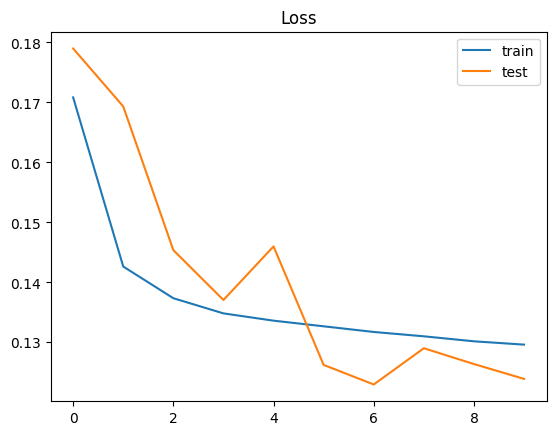

In [79]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

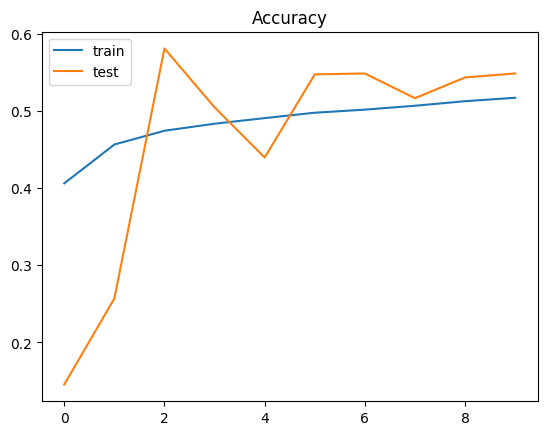

In [80]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [119]:
y_prob = lstm.predict(X_test)

1407/1407 [==============================] - 67s 47ms/step


In [126]:
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

Classification Report & Confusion Matrix

In [127]:
print("Classification Report:\n", classification_report(y_true, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.64      0.61      6930
           1       0.22      0.53      0.32      3434
           2       0.39      0.09      0.14      4549
           3       0.41      0.44      0.43      9251
           4       0.76      0.66      0.71     20836

    accuracy                           0.55     45000
   macro avg       0.47      0.47      0.44     45000
weighted avg       0.58      0.55      0.55     45000



In [129]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, average_precision_score, matthews_corrcoef

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)



# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'MCC: {mcc:.4f}')

Accuracy: 0.5460
Precision: 0.5810
Recall: 0.5460
F1 Score: 0.5473
MCC: 0.3787


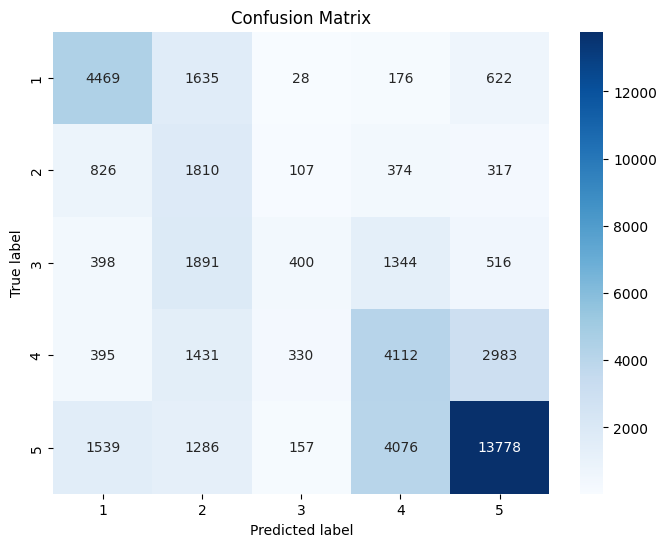

In [130]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

ROC/AUC Curves

In [108]:
from sklearn.preprocessing import label_binarize
num_classes = 5

actual_binarized = label_binarize(y_test, classes=range(num_classes))

In [109]:
# Calculate ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(actual_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

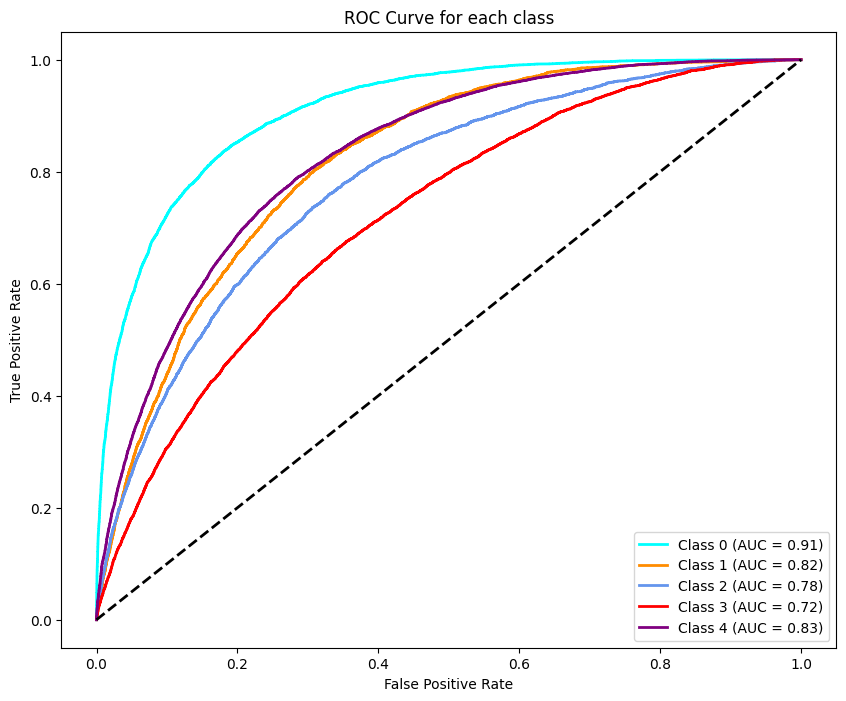

In [110]:
from itertools import cycle

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'purple'])  # Add more colors if needed

for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc="lower right")
plt.show()

Predict on bookings.com text for evaluation

In [100]:
def predict_rating(text):
    input = [text]
    sequences = tokenizer.texts_to_sequences(input)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)

    predictions = lstm.predict(padded_sequences)
    predicted_rating = int(np.argmax(predictions)) + 1
    
    print(predicted_rating)

In [106]:
predict_rating("""
               My stay at this hotel was a nightmare. The room was dirty, 
               with stains on the sheets and a strange odor. The staff was unhelpful 
               and seemed disinterested in addressing my concerns. I would not recommend this place to anyone.
               """)

1/1 [==============================] - 0s 82ms/step
1


In [101]:
predict_rating("""
               My expectations were low, but this hotel still managed to disappoint. 
               The room was mediocre, and the amenities were lacking. The staff was 
               indifferent, and the location wasn't convenient. It's not the worst, 
               but there are definitely better options out there
               """)

1/1 [==============================] - 0s 88ms/step
2


In [102]:
predict_rating("""
               The hotel met my basic needs, but it didn't exceed expectations. The room was clean, 
               and the staff was friendly enough. However, there was nothing remarkable about the 
               experience. It's an average option for a short stay.
               """)

1/1 [==============================] - 0s 80ms/step
2


In [103]:
predict_rating("""
               I didn't expect much, but this hotel exceeded my expectations. The room was modern and well-appointed, 
               and the staff was attentive. The amenities were a nice touch, and the overall experience was positive. 
               I would recommend it to others.
               """)

1/1 [==============================] - 0s 83ms/step
4


In [105]:
predict_rating("""
               This hotel is a gem. The service is top-notch, the rooms are beautifully decorated, 
               and the location is perfect. Every detail is taken care of to ensure a flawless experience. 
               If you're looking for a five-star stay, this is the place to be.
               """)

1/1 [==============================] - 0s 80ms/step
5
